# TM10007 Assignment template

In [135]:
# Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


# Importing packages

In [141]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics

# Preprocessing steps
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Feature selection
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
## Data loading functions. Uncomment the one you want to use
# from worcgist.load_data import load_dat
from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



The number of samples: 115
The number of columns: 494


## Creating a split in the data

A training and test set are created. The training set will be used to fit the classifier, while the test set is remained untouched until it is used for testing the trained classifier.

Split is stratified so labels are present in both sets in same proportions.

In [ ]:
# Extract columns with labels
Y = data.pop('label').replace({'lipoma':0, 'liposarcoma':1}) #moeten we misschien nog ook de ID poppen?

# Extract the rest of the data (without the labels)
X = data

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, stratify=Y) # ONDERBOUWEN IN REPORT

print(f'Size of training set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')

58
Size of training set: (92, 493)
Size of test set: (23, 493)


## Inspecting distribution of features
To determine data distribution of train set

### Visually inspect distribution of features

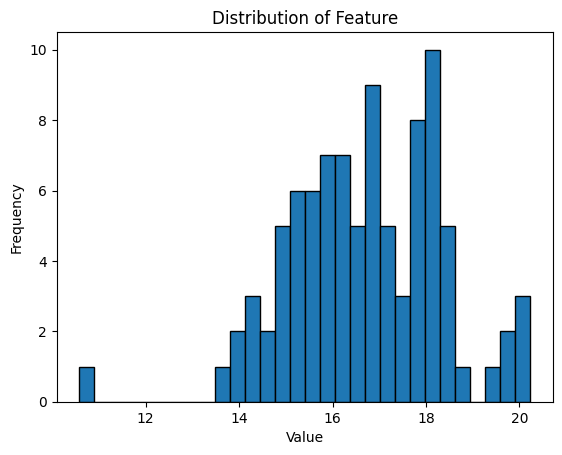

In [ ]:
# Check if Gaussian distribution per column
# if Gaussian distribution, take mean for filling empty cells (later in script)
# if not Gaussion distribution (and outliers or skewed), take median for filling empty cells (later in script)

# plt.hist(X_train.iloc[:, 15], bins=30, edgecolor='k') # Change number of colum to see distribution (between width dataframe)
plt.hist(X_train['PREDICT_original_tf_Gabor_entropy_F0.2_A1.57'], bins=30, edgecolor='k') # Change number of colum to see distribution (between width dataframe)


plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# print(X_train.head())

### Determining data distribution of train set

In [ ]:
# Definieer alpha voor de significantietest BEARGUMENTEREN WAAROM DEZE TEST IN REPORT + WAARDE
alpha = 0.05

# Initialiseer een teller voor normaal verdeelde kolommen
normal_distributed_columns_count = 0

# Loop door elke kolom in de DataFrame en voer Shapiro-Wilk test uit
for column in X_train:
    stat, p = shapiro(X_train[column])
    if p > alpha:
        # print(column)
        normal_distributed_columns_count += 1  # Tel kolom als normaal verdeeld

print(f"Aantal normaal verdeelde kolommen: {normal_distributed_columns_count}")


Aantal normaal verdeelde kolommen: 75


In [ ]:
# print(X_train.head())
# print(Y.head())

## Preprocessing Data

### Missing Values
Determining cells with missing values and filling these

In [ ]:
# Check missing values
missing_values = X_train.isnull().sum()
print(len(missing_values[missing_values > 0]))

0


In [ ]:
# Filling missing values with correct value based on type of distribution per column

# Definieer alpha voor de significantietest BEARGUMENTEREN WAAROM DEZE TEST IN REPORT + WAARDE
alpha = 0.05

# Initialiseer een teller voor normaal verdeelde kolommen
normal_distributed_columns_count = 0
not_normal_distributed_columns_count = 0
nans_found_in_column_count = 0

# Loop door elke kolom in de DataFrame en voer Shapiro-Wilk test uit
for column in X_train:
    stat, p = shapiro(X_train[column])
    if p > alpha:
        # print(column)
        normal_distributed_columns_count += 1  # Tel kolom als normaal verdeeld
        if X_train[column].isna().sum() > 0:
            X_train[column].fillna(X_train[column].mean)
            nans_found_in_column_count += 1
    else:
        not_normal_distributed_columns_count += 1  # Tel kolom als normaal verdeeld
        if X_train[column].isna().sum() > 0:
            X_train[column].fillna(X_train[column].median)
            nans_found_in_column_count += 1

print(f'The number of normal distributed columns is: {normal_distributed_columns_count}')
print(f'The number of not normal distributed columns is: {not_normal_distributed_columns_count}')
print(f'The number of columns where nans were filled: {nans_found_in_column_count}')

The number of normal distributed columns is: 75
The number of not normal distributed columns is: 418
The number of columns where nans were filled: 0


### Feature Scaling
Scale features in Train set

In [139]:
# Define counter for columns with many outliers
columns_with_many_outliers_count = 0

for column in X_train:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate number of outliers
    outliers = X_train[(X_train[column] < (Q1 - 1.5 * IQR)) | (X_train[column] > (Q3 + 1.5 * IQR))]
    outliers_count = outliers.shape[0]

    # Define what 'many' outliers mean
    if outliers_count > 0.05 * X_train.shape[0]:
        columns_with_many_outliers_count += 1
        # print(f"{column} has many outliers: {outliers_count} outliers")

print(f"Number of columns with many outliers: {columns_with_many_outliers_count}")


Number of columns with many outliers: 187


In [165]:
# Scaler

# scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)



# Inspecting data

## Feature selection and extraction

In [164]:
## Without scaling (for X_train)
# min_features = 1
# clf  = LogisticRegression(solver='liblinear')
# cv = StratifiedKFold(2)

# rfecv = RFECV(
#     estimator=clf,
#     cv=cv,
#     # scoring = "accuracy",
#     min_features_to_select = min_features
# )

# rfecv.fit(X_train, Y_train)

# print(f"Optimal number of features: {rfecv.n_features_}")

# if rfecv.n_features_ > len(X_train.index):
#   pca = decomposition.PCA(n_components=0.95)
#   pca.fit(X_train)
#   X_train = pca.transform(X_train)


## With / after scaling (for X_train_robust_scaled_df)
min_features = 1
clf  = LogisticRegression(solver='liblinear')
cv = StratifiedKFold(2)

rfecv = RFECV(
    estimator=clf,
    cv=cv,
    # scoring = "accuracy",
    min_features_to_select = min_features
)

rfecv.fit(X_train_scaled_df, Y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

if rfecv.n_features_ > len(X_train_scaled_df.index):
    pca = decomposition.PCA(n_components=0.95)
    pca.fit(X_train_scaled_df)
    X_train_scaled_df = pca.transform(X_train_scaled_df)




Optimal number of features: 9
